### Uplift-моделирование

- есть набор данных маркетинговых кампаний

- будет проведено uplift-моделирование 3 способами: одна модель с признаком коммуникации (S-learner), модель с трансформацией таргета и вариант с двумя независимыми моделями

- в конце сравнение метрик uplift@10%, uplift@20%, uplift@30% этих 3 моделей

- модель UpliftTreeClassifier

In [ ]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

### Подготовка данных

In [ ]:
df = pd.read_csv('/content/uplift_data.csv')
df_copy = df.copy()
df.tail(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0
63999,1,472.82,0,1,Surburban,0,Web,Discount,0


In [ ]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}, inplace=True)

df['zip_code'].replace({'Urban': 1, 'Surburban': 0, 'Rural': 0}, inplace=True)

df['channel'].replace({'Phone': 1, 'Multichannel': 0, 'Web': 0}, inplace=True)

for fixed_feature in ['treatment', 'target', 'zip_code', 'channel']:
  print(df[fixed_feature].value_counts())
  print('------------------')

1    42694
0    21306
Name: treatment, dtype: int64
------------------
0    54606
1     9394
Name: target, dtype: int64
------------------
0    38339
1    25661
Name: zip_code, dtype: int64
------------------
0    35979
1    28021
Name: channel, dtype: int64
------------------


Теперь все признаки численные. Осталось разобраться с масштабом, а точнее с history/recency.

In [ ]:
df.recency = df.recency / max(df.recency)
df.history = df.history / max(df.history)

df.describe()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,0.480311,0.072352,0.551031,0.549719,0.400953,0.502250,0.437828,0.667094,0.146781
std,0.292299,0.076558,0.497393,0.497526,0.490095,0.499999,0.496123,0.471257,0.353890
min,0.083333,0.008963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.019325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.047254,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.750000,0.097329,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Разделение данных

In [ ]:
# сперва разделю данные на выборки W и X
from sklearn.utils import shuffle

W = df['treatment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target', 'treatment'], axis=1), df['target'], 
                                                    test_size=0.25, random_state=197)

print(X_train.shape, X_test.shape)

(48000, 7) (16000, 7)


In [ ]:
# выборку treat тоже поделю на 2 части
W_train, W_val = train_test_split(W, test_size=0.25, random_state=197)

print(W_train.shape, W_val.shape)

(48000,) (16000,)


### Подготовка к обучению

In [ ]:
# словарь с результатами
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

### Модель S-learner

In [ ]:
#!pip install catboost scikit-uplift

In [ ]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

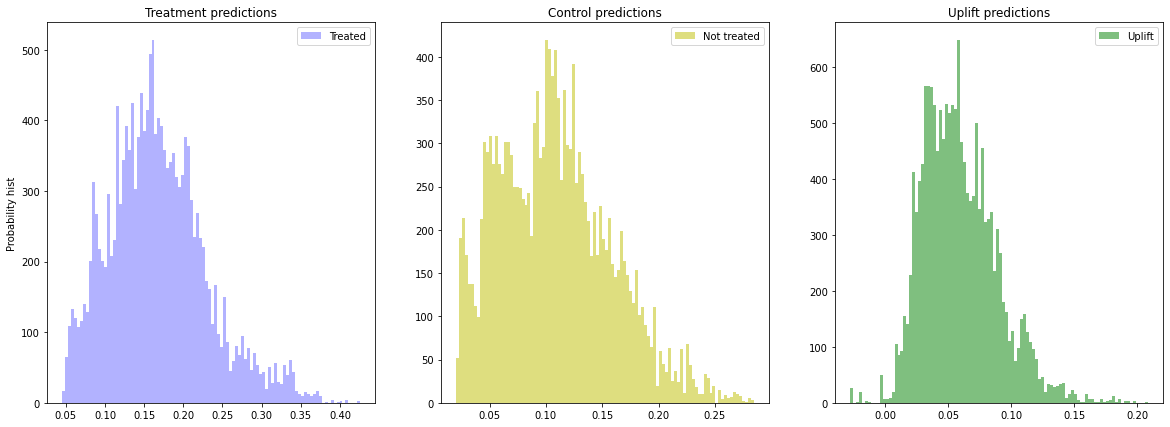

In [ ]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=197, silent=True))
sm = sm.fit(X_train, y_train, W_train)

uplift_sm = sm.predict(X_test)

sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=W_val, strategy='by_group', k=0.1)
sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=W_val, strategy='by_group', k=0.2)
sm_score30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=W_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloLearn')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)
models_results['uplift@30%'].append(sm_score30)

# условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [ ]:
# важные признаки
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.038874
1,history,17.762292
2,treatment,17.190456
3,recency,14.969363
4,used_bogo,9.545760
5,used_discount,9.326791
6,channel,6.108056
7,zip_code,5.058409


### Class Transformation

In [ ]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, W_train)

uplift_ct = ct.predict(X_test)

ct_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=W_val, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=W_val, strategy='by_group', k=0.2)
ct_score30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=W_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)
models_results['uplift@30%'].append(ct_score30)

### Two Models

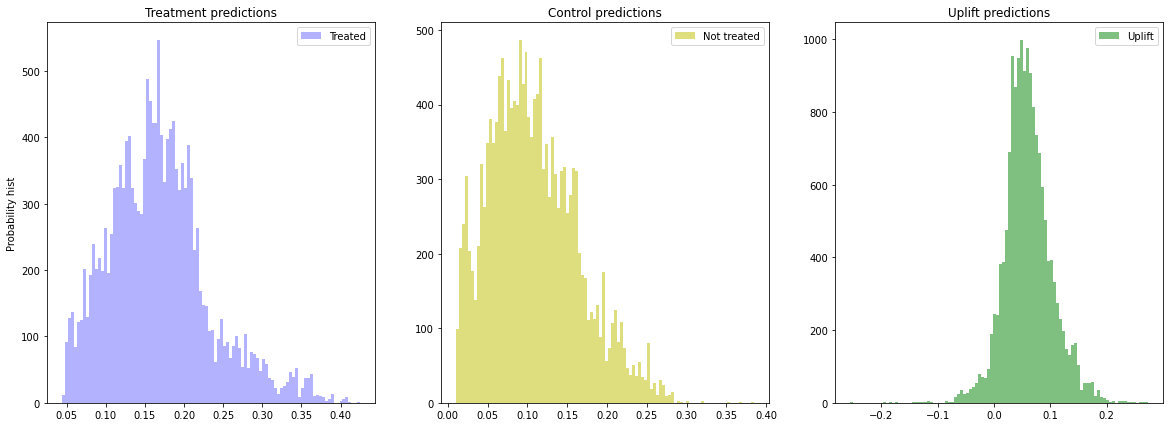

In [ ]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, W_train
)

uplift_tm = tm.predict(X_test)
tm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=W_val, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=W_val, strategy='by_group', k=0.2)
tm_score30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=W_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)
models_results['uplift@30%'].append(tm_score30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### Результаты

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@10%,uplift@20%,uplift@30%
2,TwoModels,0.091042,0.070599,0.079524
0,SoloLearn,0.087584,0.080059,0.077466
1,ClassTransformation,0.090508,0.066313,0.069253


Все модели выглядят достойно.

### UpliftTreeClassifier

In [ ]:
features = [col for col in X_train]

In [ ]:
#!pip install causalml

CPU times: user 1.53 s, sys: 67.1 ms, total: 1.6 s
Wall time: 2.06 s


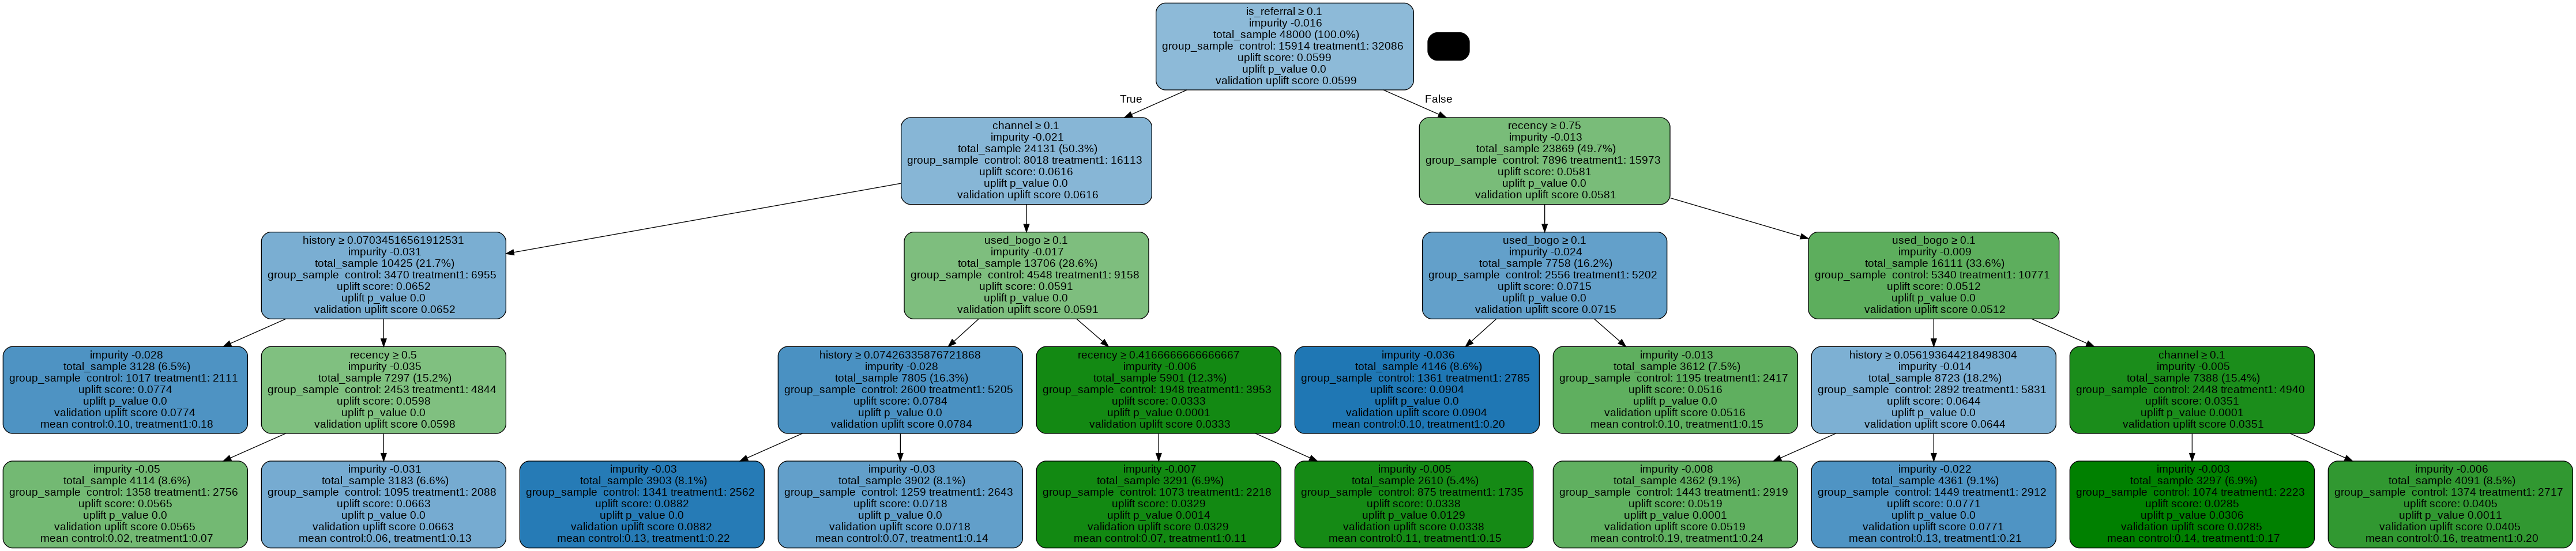

In [ ]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=int(len(X_train) * 0.05), min_samples_treatment=100,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=W_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Полученное дерево:

*validation_uplift_score* показывает, с какими клиентами взаимодействовать, с какими нет. [-1.0: 1.0]: чем больше, тем привлекательнее группа для звонков/уведомлений/т.д и им названивать в первую очередь. 

*p_value* - почти во всех терминалах близка к 0, значит, можно доверять значимым различиям в распределениях

*impurity* после каждого предиката равна 0. Разделение на группы отличное.

Хорошо сработал UpliftTree. Однако в целом можно было сделать прунинг последнего слоя, т.к. показатели и так хорошие на предпоследнем.

